# Importing

In [1]:
from xd.metrics import ssim, feature_agreement, sign_agreement, rank_correlation, normalize
from xd.disagreement import compute_heatmaps
import utils

import json
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from PIL import Image
import os
import seaborn as sns
import torch
import warnings

warnings.filterwarnings('ignore')

# Configurations

In [2]:
# Select environment
DATASET_PATH, _ = utils.get_path('local')
print(f'Dataset path: {DATASET_PATH}')

Dataset path: ../datasets/


# Load from saved explanations

In [3]:
blackboxes = utils.BLACK_BOX_NAMES
methods = utils.METHOD_NAMES

def load_explanations(dataset):
    explanations = dict()
    base_directory = os.path.join(utils.SAVED_EXPLANATIONS_DIR, dataset)
    for blackbox in blackboxes:
        explanations[blackbox] = dict()
        directory = os.path.join(base_directory, blackbox)
        print(directory)
        for file in os.listdir(directory):
            method = os.path.basename(file).split('.')[0]
            path = os.path.join(directory, file)
            exp = torch.load(path)
            explanations[blackbox][method] = exp
    return explanations

explanations_pneumothorax = load_explanations(utils.DS_PNEUMOTHORAX)
explanations_pneumonia = load_explanations(utils.DS_PNEUMONIA)

print(f'Blackboxes: {blackboxes}')
print(f'Methods: {methods}')

../explanations\Pneumothorax\InceptionV3
../explanations\Pneumothorax\ResNet
../explanations\Pneumonia\InceptionV3
../explanations\Pneumonia\ResNet
Blackboxes: ['InceptionV3', 'ResNet']
Methods: ['DeepLift', 'GradientShap', 'GuidedBackprop', 'GuidedGradCam', 'IntegratedGradients', 'LRP', 'Occlusion', 'Saliency']


# Visualizing

In [4]:
def get_annot_array(data: np.ndarray):
    str_array = np.char.mod('%.2f', data)
    str_array[str_array == 'nan'] = '-'
    return str_array

In [5]:
def visualize_many(heatmaps, metric_name='', **options):
    num_black_boxes = len(heatmaps.keys())
    fig, axes = plt.subplots(nrows=1, ncols=num_black_boxes, figsize=(18,6))
    
    if num_black_boxes == 1:
        axes = [axes]
    
    for i, blackbox in enumerate(heatmaps.keys()):
        heatmap_dict = heatmaps[blackbox]
        methods = heatmap_dict['methods']
        data = heatmap_dict['data']
        
        annot = get_annot_array(data)
        data[np.isnan(data)] = 0
        
        # Plot
        sns.heatmap(
            data,
            annot=annot,
            ax=axes[i],
            xticklabels=methods,
            yticklabels=methods,
            fmt='',
            **options
        ).set(title=blackbox)
        axes[i].tick_params(left=False, bottom=False)
    
    fig.suptitle(metric_name)
    return fig, axes

In [6]:
def visualize_many_with_k(map_k_and_heatmaps, ks, metric_name='', **options):
    rows, cols = len(ks), 2
    fig, axes = plt.subplots(rows, cols, figsize=(18, 22))
    cbar_ax = fig.add_axes([.91, .4, .015, .23])
    
    # For common legend
    handles, labels = None, None
    for row, k in enumerate(ks):
        heatmaps = map_k_and_heatmaps[k]
        
        for col, blackbox in enumerate(heatmaps.keys()):
            # Get methods and heatmaps
            heatmap_dict = heatmaps[blackbox]
            methods = heatmap_dict['methods']
            data = heatmap_dict['data'].copy()
            
            annot = get_annot_array(data)
            data[np.isnan(data)] = 0
            
            # Plot
            ax = axes[row][col]
            sns.heatmap(
                data=data,
                annot=annot,
                ax=ax,
                xticklabels=methods,
                yticklabels=methods,
                fmt='',
                cbar_ax=cbar_ax,
                **options
            ).set(title=f'{blackbox} (k={k})')
            ax.tick_params(left=False, bottom=False)
    
    fig.suptitle(metric_name)
    fig.tight_layout(rect=[0, 0, .9, 1], pad=2)
    return fig, axes

In [7]:
def get_top_k(exp, k):
    _, top = torch.topk(exp.flatten().abs(), k)
    old_size = exp.size()
    result = torch.zeros(exp.nelement())
    result[top] = 1
    result = result.reshape(old_size).bool()
    return result

In [8]:
def visualize(explanations, metric, metric_name, ks=None, **options):
    heatmap = dict()
    fig, ax = None, None

    if ks != None:
        for k in ks:
            heatmap[k] = compute_heatmaps(explanations, metric, k=k)

        fig, ax = visualize_many_with_k(
            heatmap, ks, metric_name, **options)
    else:
        heatmap = compute_heatmaps(explanations, metric)
        fig, ax = visualize_many(heatmap, metric_name, **options)
    return fig, ax

In [9]:
DATASET_MAP = {
    utils.DS_PNEUMOTHORAX: explanations_pneumothorax,
    utils.DS_PNEUMONIA: explanations_pneumonia
}

METRIC_MAP = {
    'Feature Agreement': {
        'f': feature_agreement,
        'use_ks': True,
        'mask_transform': False,
        'value_range': [0, 1],
    },
    'Sign Agreement': {
        'f': sign_agreement,
        'use_ks': True,
        'mask_transform': False,
        'value_range': [0, 1],
    },
    'Rank Correlation': {
        'f': rank_correlation,
        'use_ks': False,
        'mask_transform': True,
        'value_range': [-1, 1],
    },
    'SSIM': {
        'f': ssim,
        'use_ks': False,
        'mask_transform': False,
        'value_range': [-1, 1],
    }
}
PERCENTAGES = [0.05, 0.1, 0.2]
NUM_PIXELS = np.prod(np.array(utils.INPUT_SIZE))
Ks = list(map(lambda p: int(NUM_PIXELS * p), PERCENTAGES))
VISUALIZATION_OPTIONS = {
    'vmin': 0,
    'vmax': 1,
    'cmap': 'Blues'
}

In [10]:
def load_mask():
    with open(os.path.join(utils.SAVED_EXPLANATIONS_DIR, 'test_files.json'), 'r') as fig:
        test_files = json.load(fig)

    masks = list(map( 
        lambda x: utils.mask_transform(Image.open(os.path.join(DATASET_PATH, 'pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax', 'png_masks', x)).convert('RGB'))[0, :, :].unsqueeze(0), 
        test_files
    ))
    masks = torch.concat(masks)
    return masks

def transform_explanations_with_mask(explanations, masks):
    explanations_masked = dict()
    for blackbox, v in explanations.items():
        explanations_masked[blackbox] = dict()
        
        for method in methods:
            exp = v[method]
            masked_explanations = []
            for i, e in enumerate(exp):
                mask = masks[i].bool()
                if mask.sum() == 0:
                    continue
                masked_explanation = e[mask]
                masked_explanations.append(masked_explanation)
            explanations_masked[blackbox][method] = masked_explanations
    return explanations_masked

In [11]:
def visualize_and_save(dataset, metric_name):
    explanations = DATASET_MAP[dataset]
    
    if METRIC_MAP[metric_name]['mask_transform']:
        masks = load_mask()
        explanations = transform_explanations_with_mask(explanations, masks)
    
    # value_range = METRIC_MAP[metric_name]['value_range']

    fig, ax = visualize(
        explanations,
        METRIC_MAP[metric_name]['f'],
        metric_name,
        ks=Ks if METRIC_MAP[metric_name]['use_ks'] else None,
        **VISUALIZATION_OPTIONS
    )
    path = os.path.join(utils.FIGURES_PATH, dataset, metric_name)
    utils.make_dir_if_not_exist(path)
    fig.savefig(path, bbox_inches='tight')
    return fig, ax

## Pneumothorax Dataset

Feature Agreement

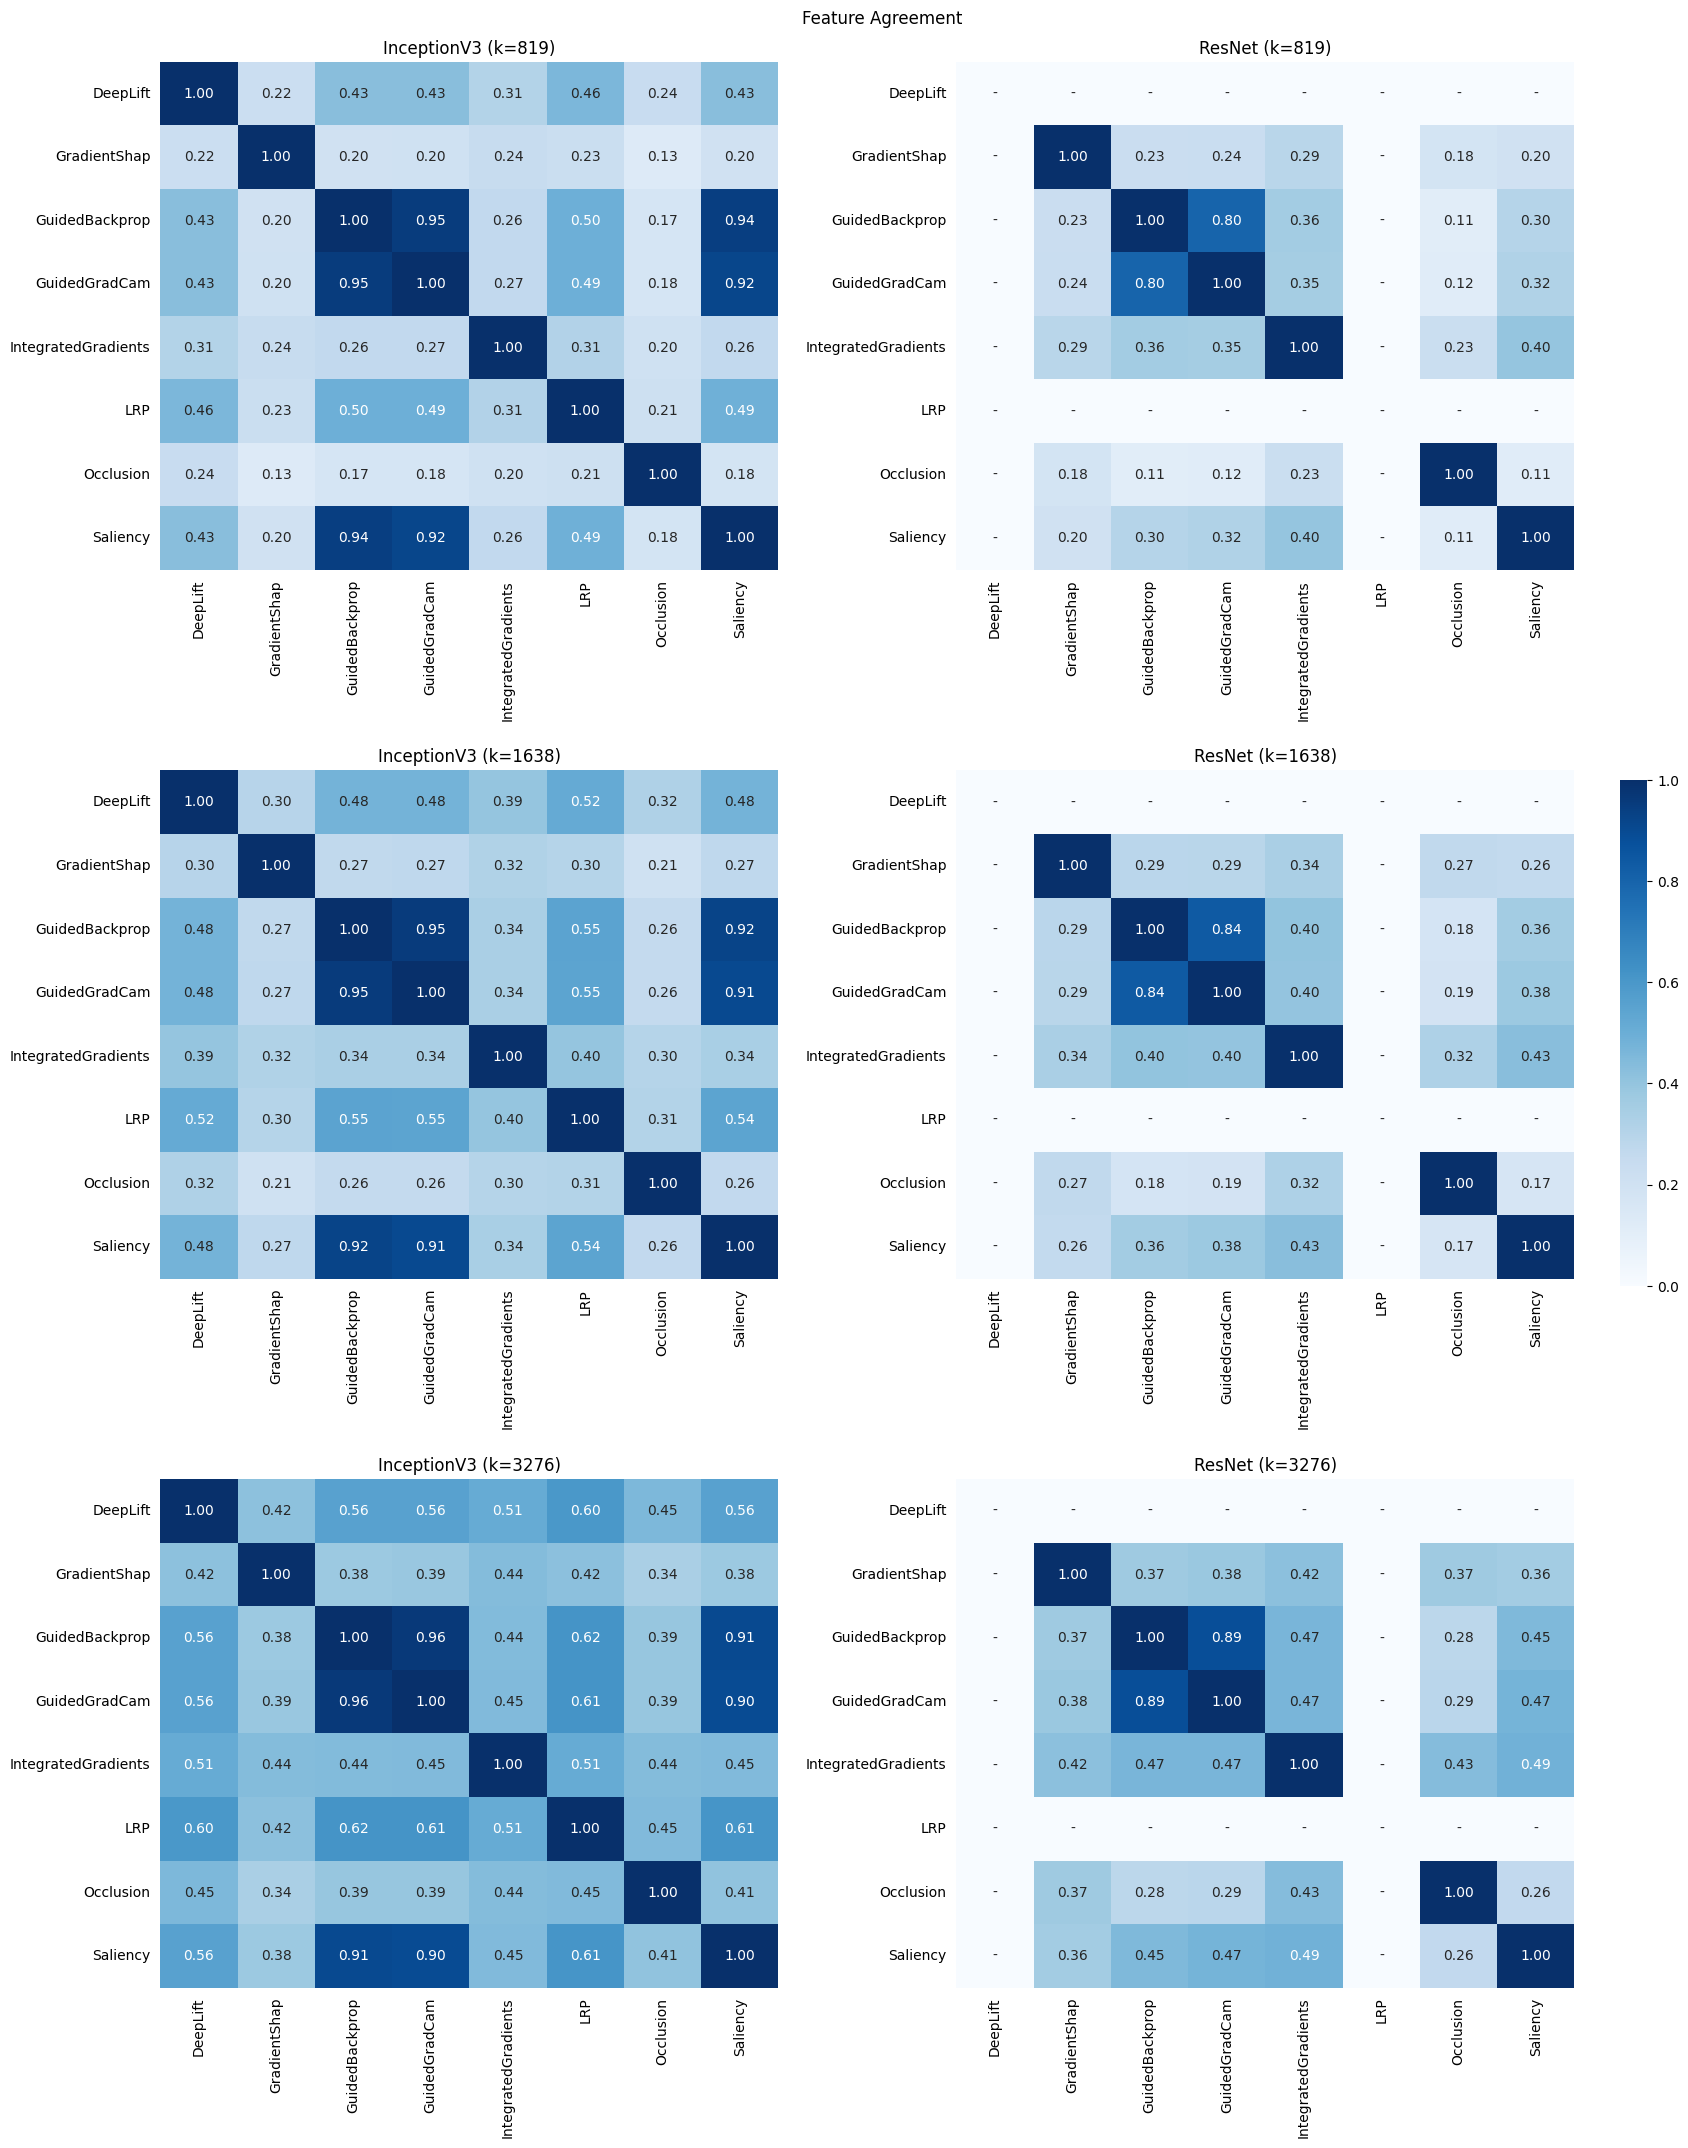

In [12]:
visualize_and_save(utils.DS_PNEUMOTHORAX, 'Feature Agreement')
plt.show()

Sign Agreement

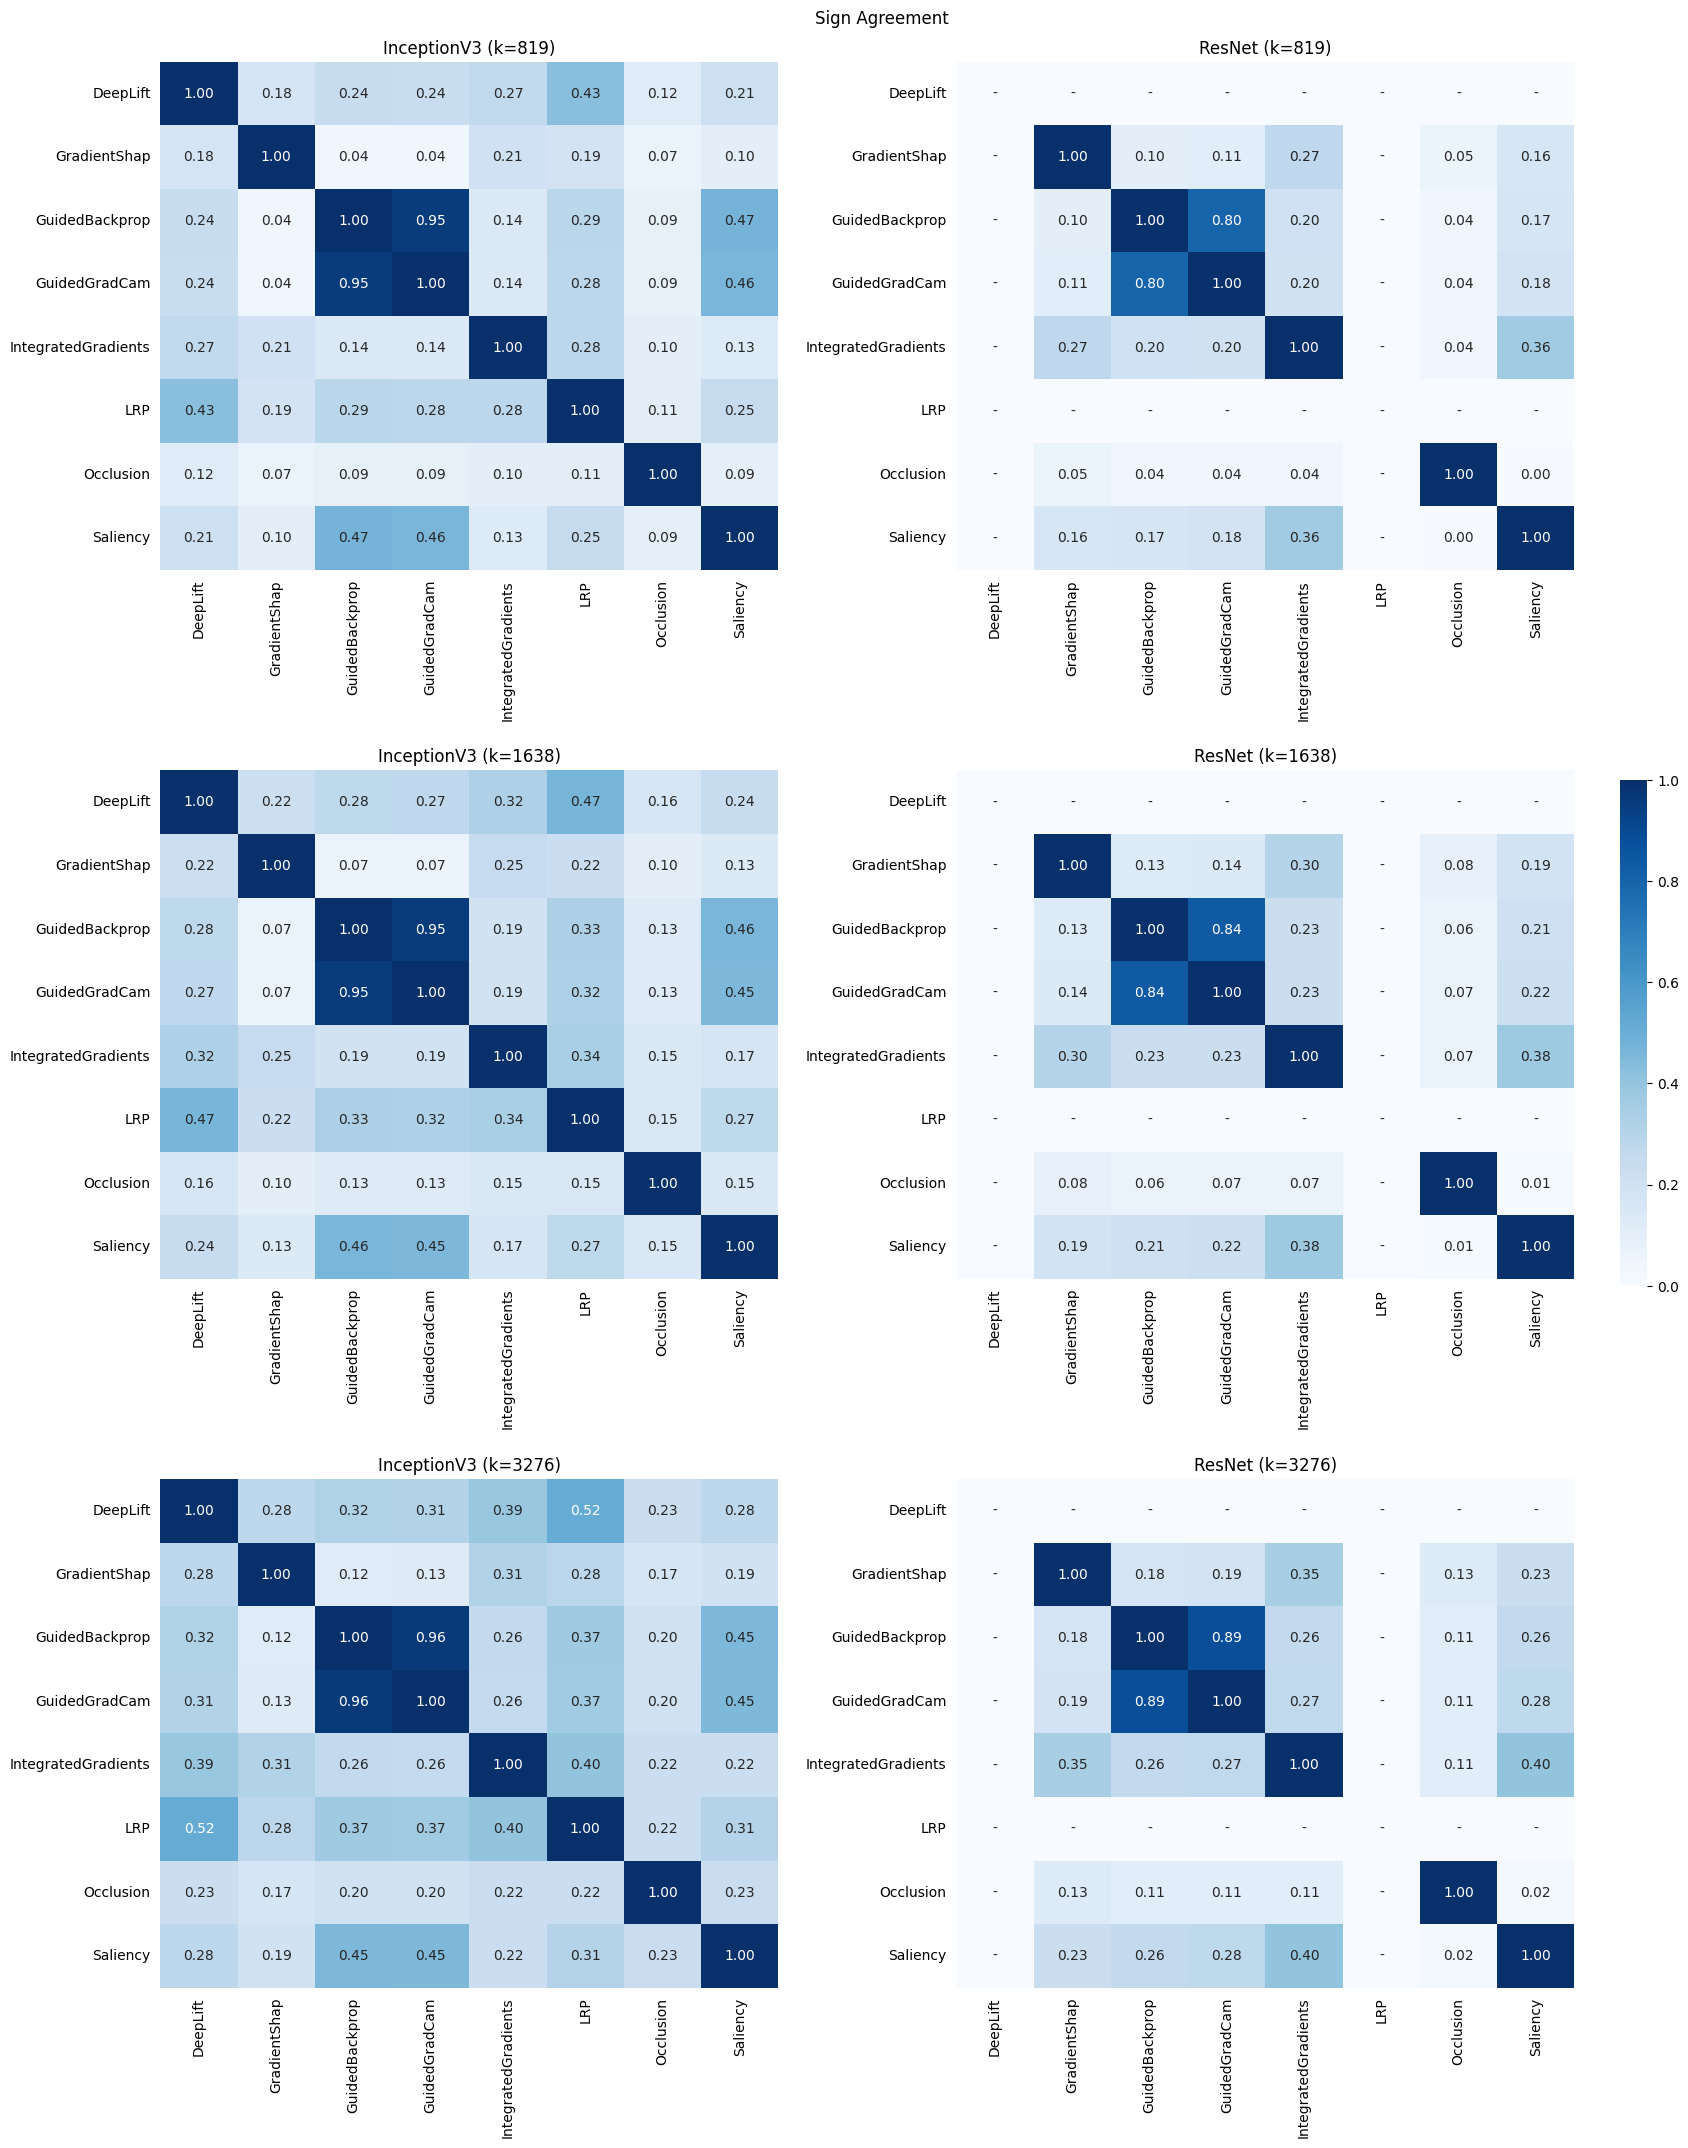

In [13]:
visualize_and_save(utils.DS_PNEUMOTHORAX, 'Sign Agreement')
plt.show()

Rank correlation

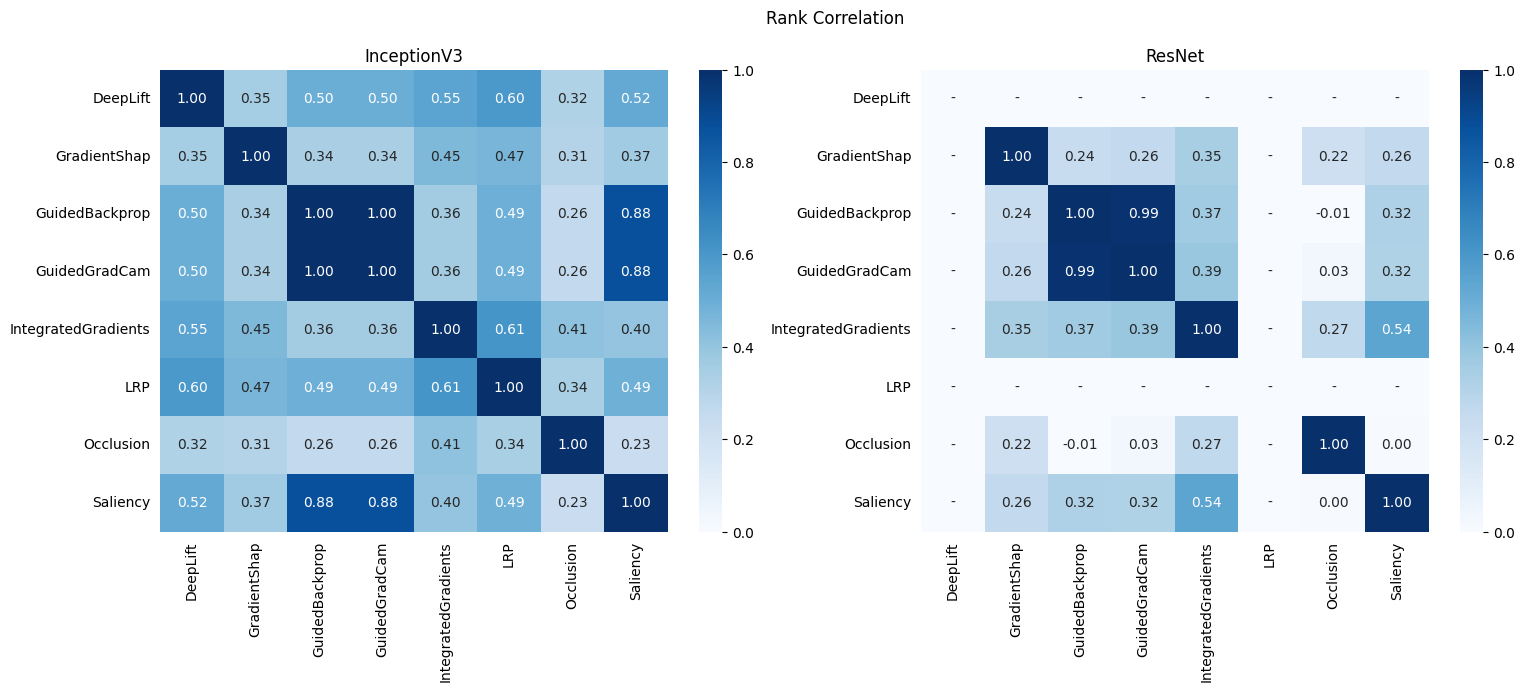

In [14]:
visualize_and_save(utils.DS_PNEUMOTHORAX, metric_name='Rank Correlation')
plt.show()

SSIM

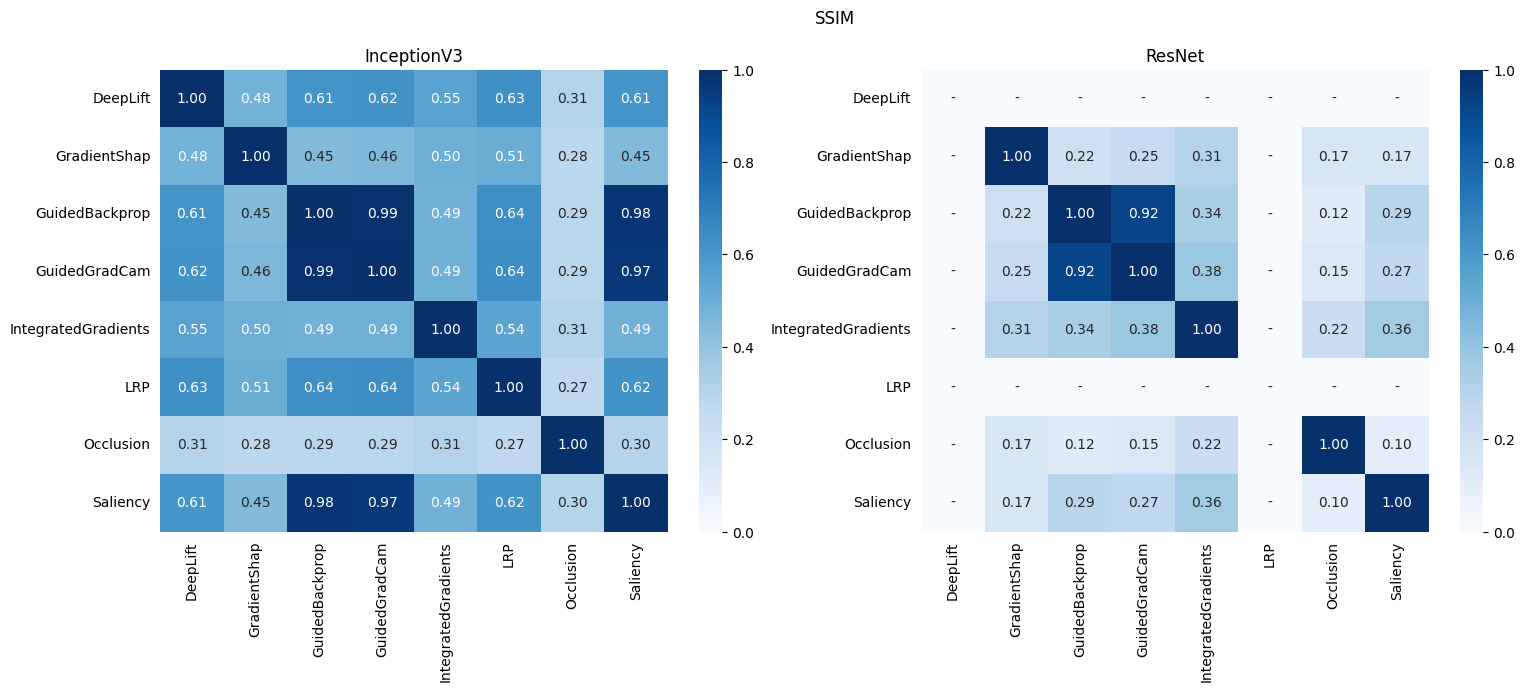

In [15]:
visualize_and_save(utils.DS_PNEUMOTHORAX, 'SSIM')
plt.show()

# Pneumonia dataset

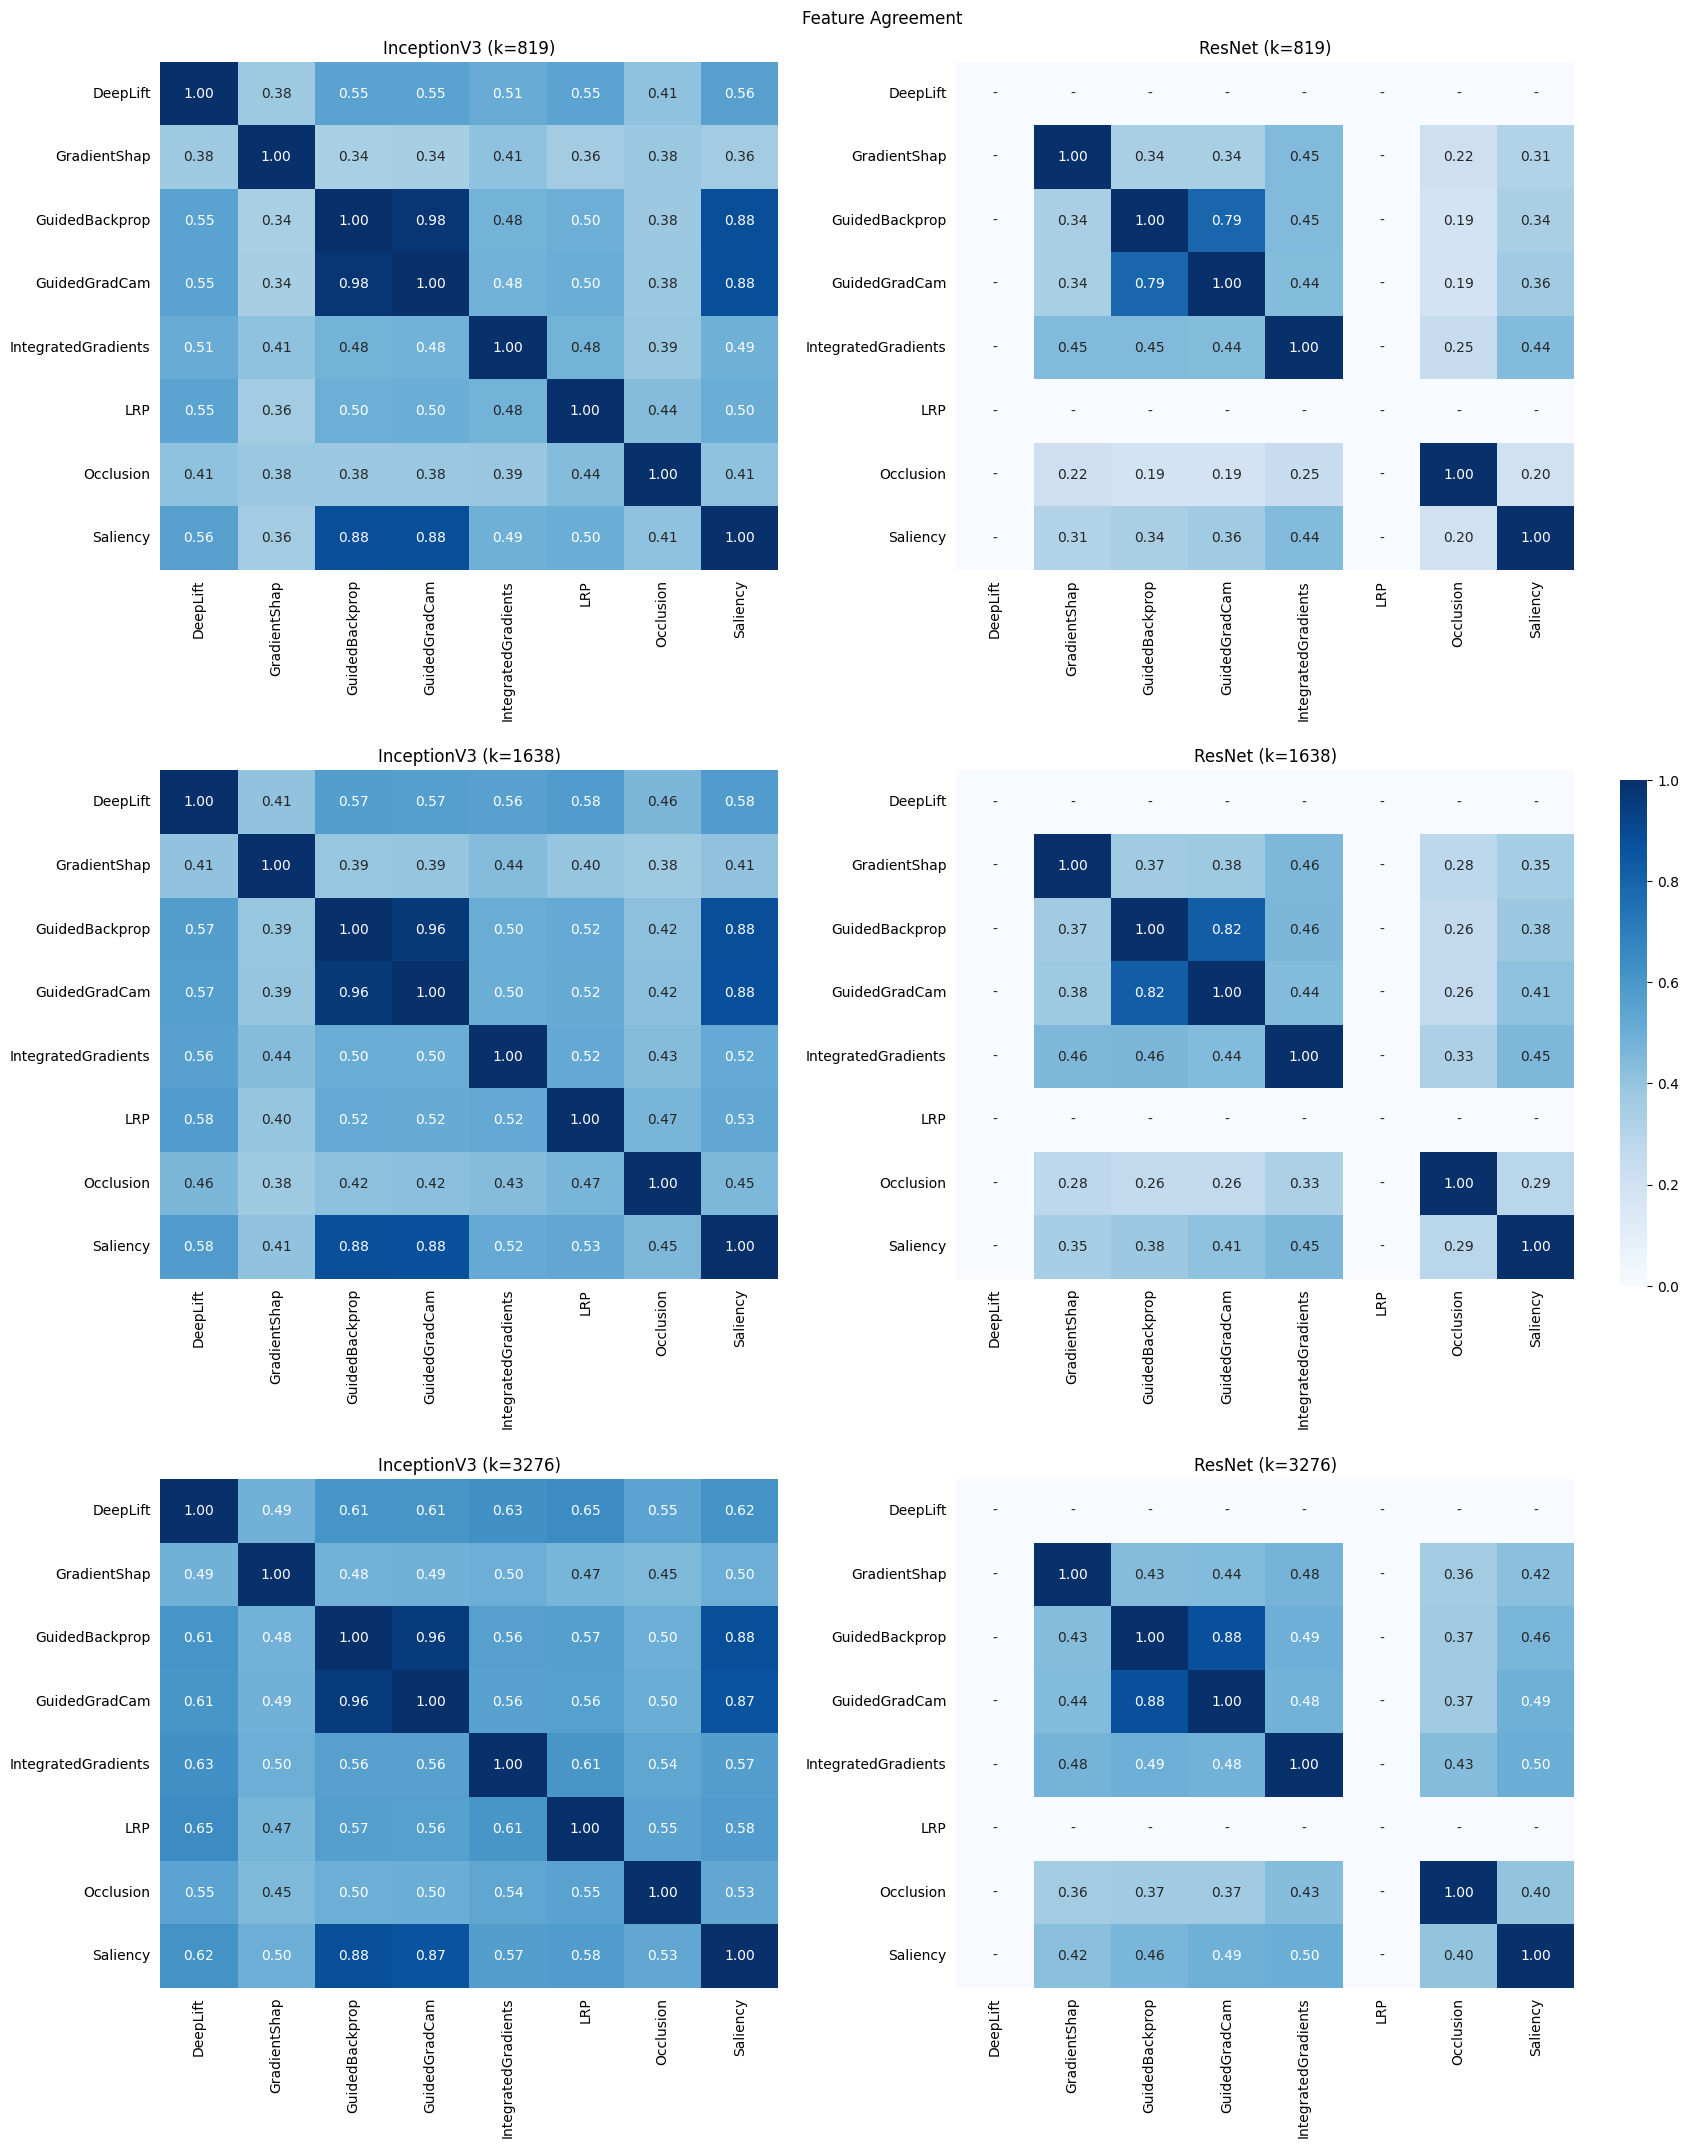

In [16]:
visualize_and_save(utils.DS_PNEUMONIA, 'Feature Agreement')
plt.show()

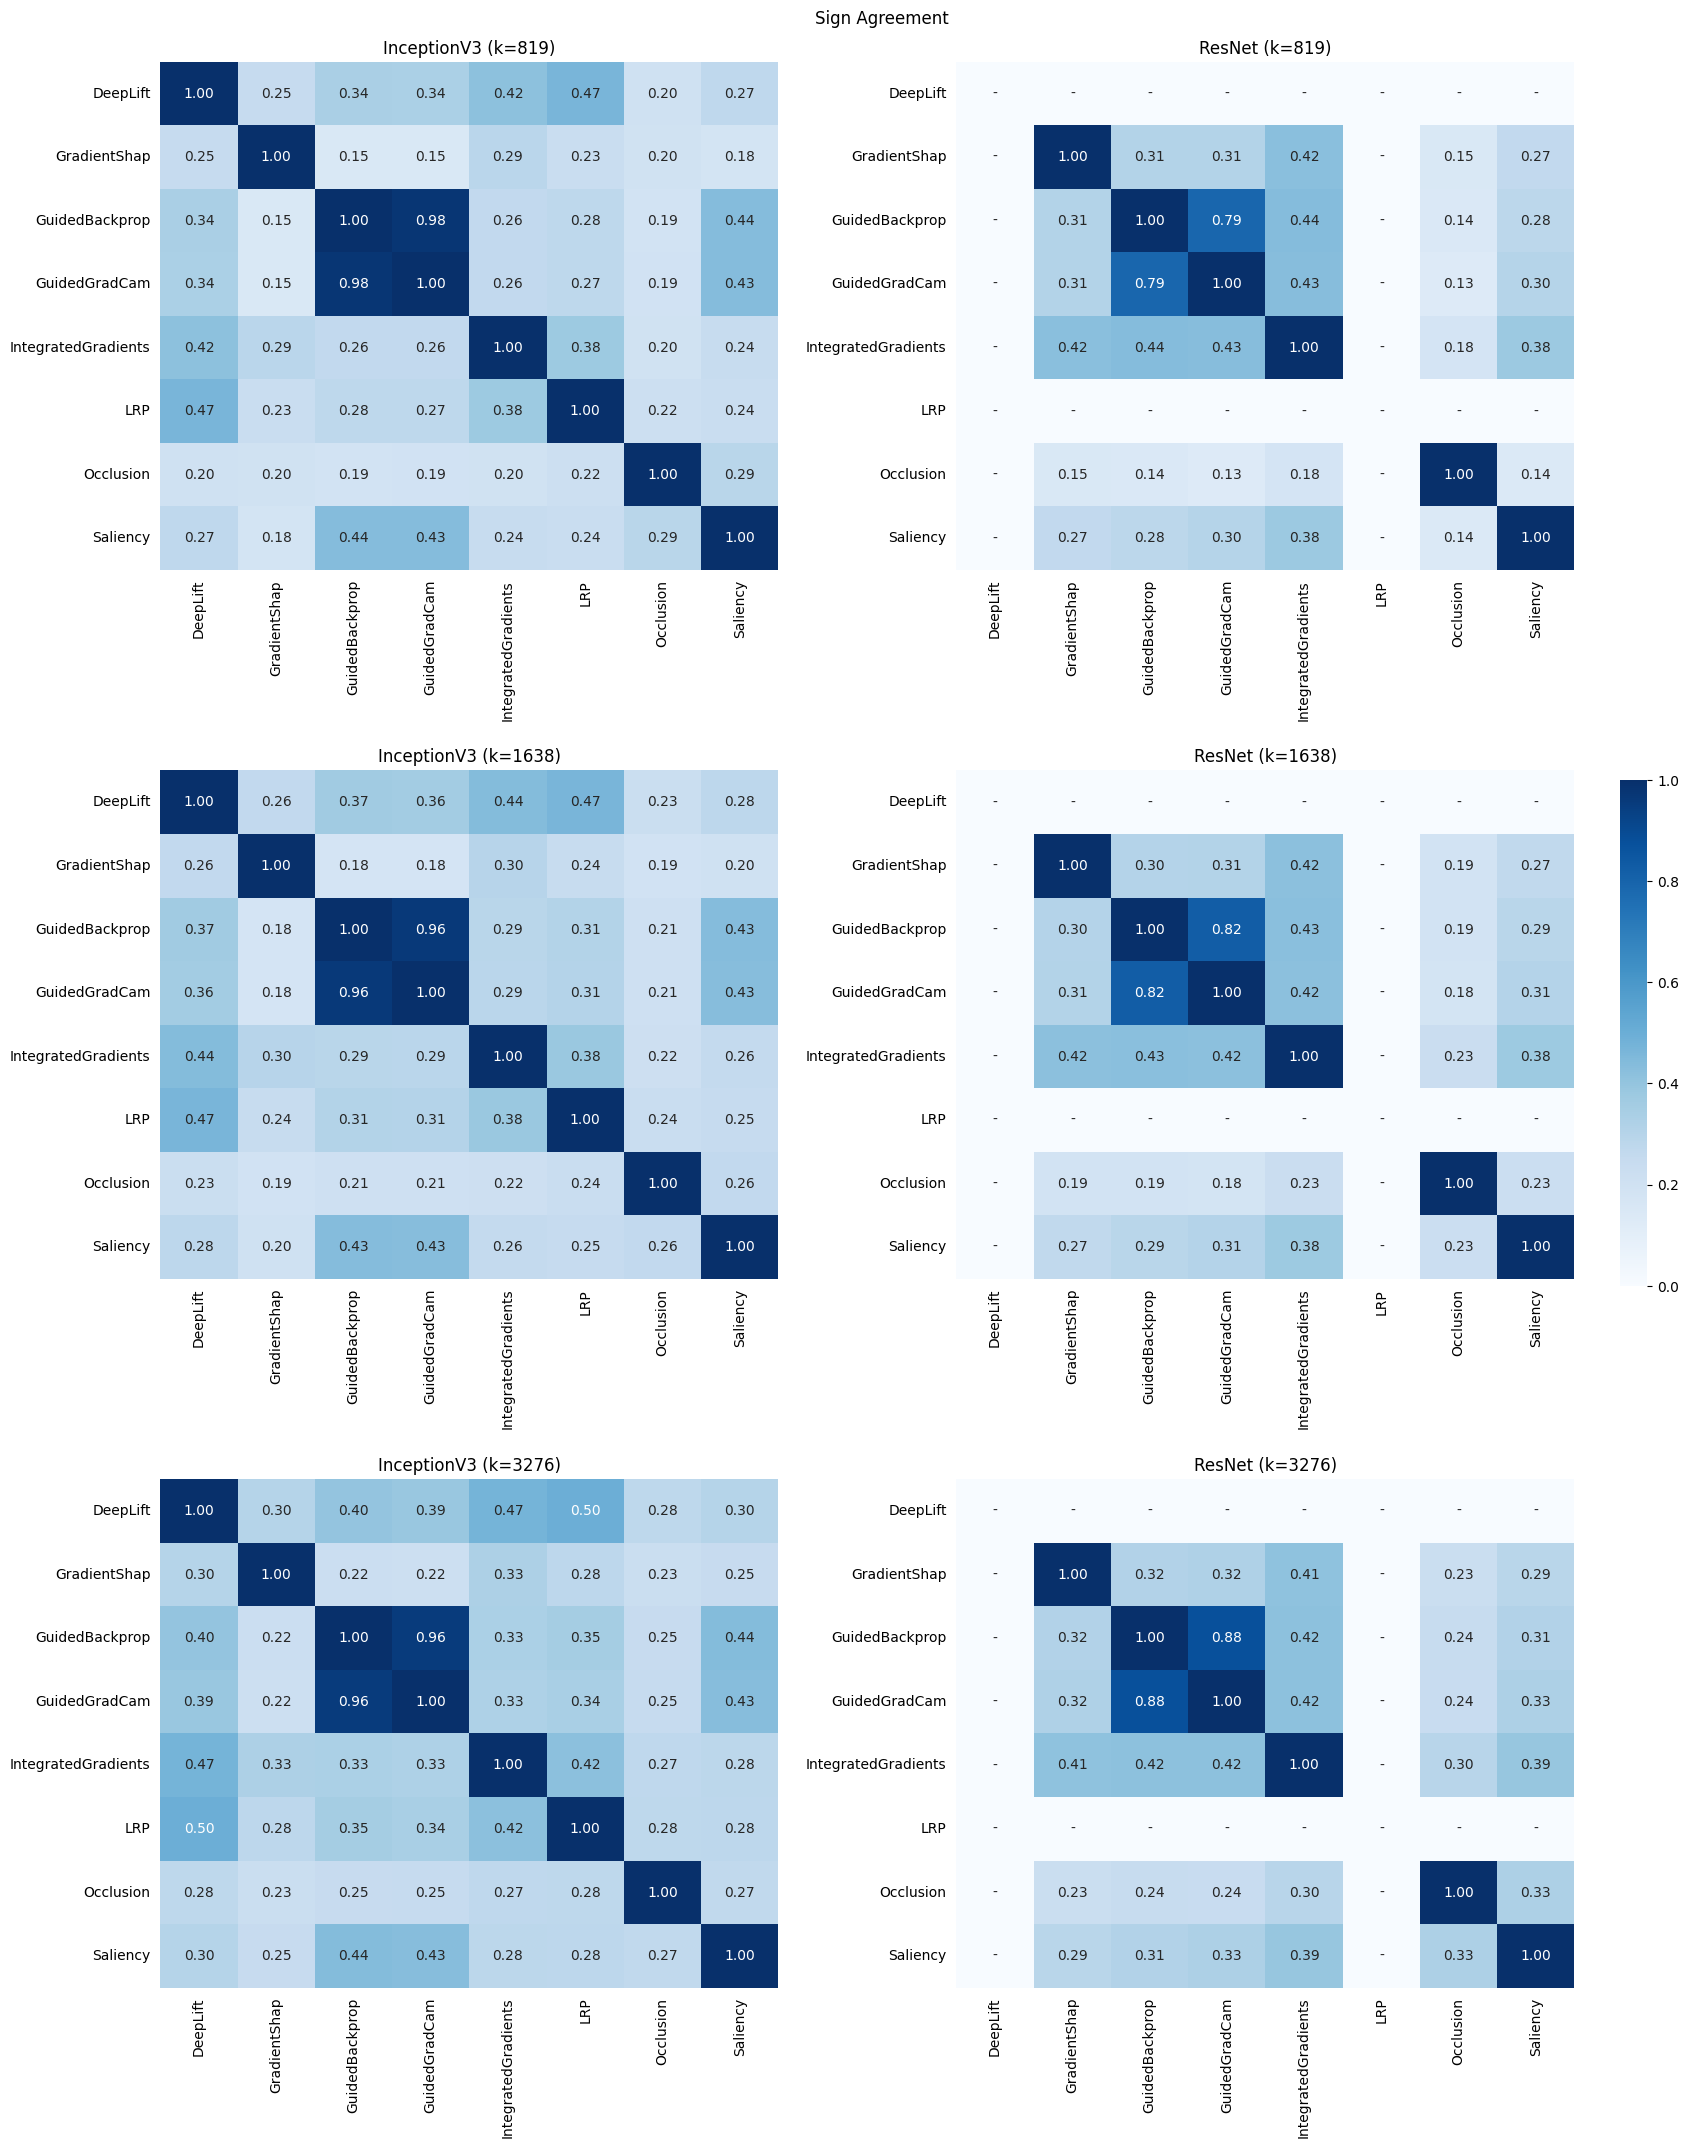

In [17]:
visualize_and_save(utils.DS_PNEUMONIA, 'Sign Agreement')
plt.show()

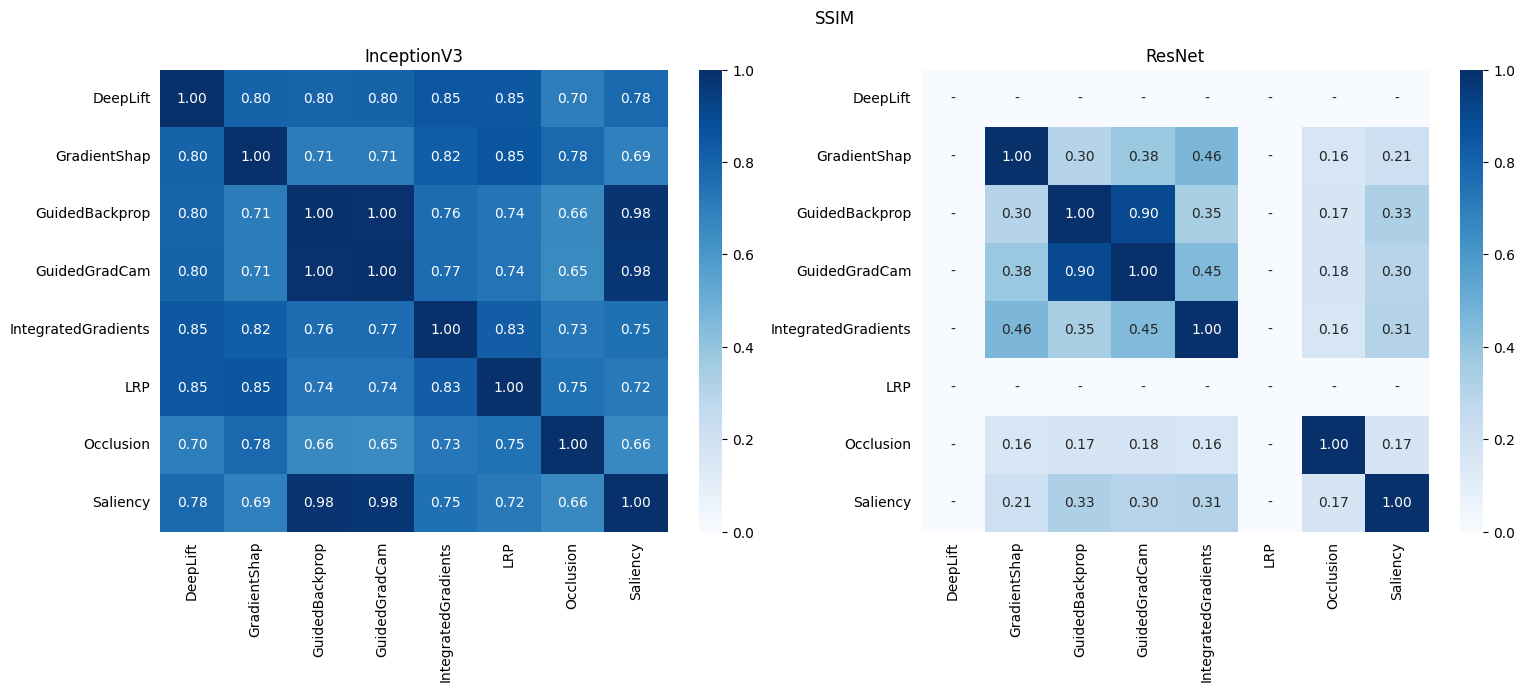

In [18]:
visualize_and_save(utils.DS_PNEUMONIA, 'SSIM')
plt.show()

# Visualize sample of saliency maps

In [19]:
def get_image_as_tensor(filename):
    return utils.mask_transform(Image.open(os.path.join(DATASET_PATH, 'pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax', 'png_images', filename)).convert('RGB'))

In [20]:
def visualize_sample_saliency(test_files, masks, explanations, blackbox, methods, index):
    num_methods = len(methods)
    row, col = 2, math.ceil(num_methods / 2) + 1
    fig, axes = plt.subplots(row, col, figsize=(26, 10))
    
    axes[0][0].imshow(get_image_as_tensor(test_files[index]).permute(1, 2, 0))
    axes[1][0].imshow(masks[index].squeeze(), cmap='gray')
    
    for i, m in enumerate(methods):
        p = sns.heatmap(
            normalize(explanations[blackbox][m][index].abs().detach().numpy()),
            ax=axes[(i + 1) // col][1 + (i % (col-1))],
            annot=False,
            cbar=False,
            cmap='viridis'
        ).set(
            xticklabels=[],
            yticklabels=[],
            title=m
        )

        plt.legend([], [], frameon=False)

    for i, ax in enumerate(axes.flat):
        ax.tick_params(axis='both', which='both', bottom=False, top=False)
        ax.set_xticks([])
        ax.set_yticks([])
        if i >= num_methods:
            ax.axis('off')
        
    return fig, axes

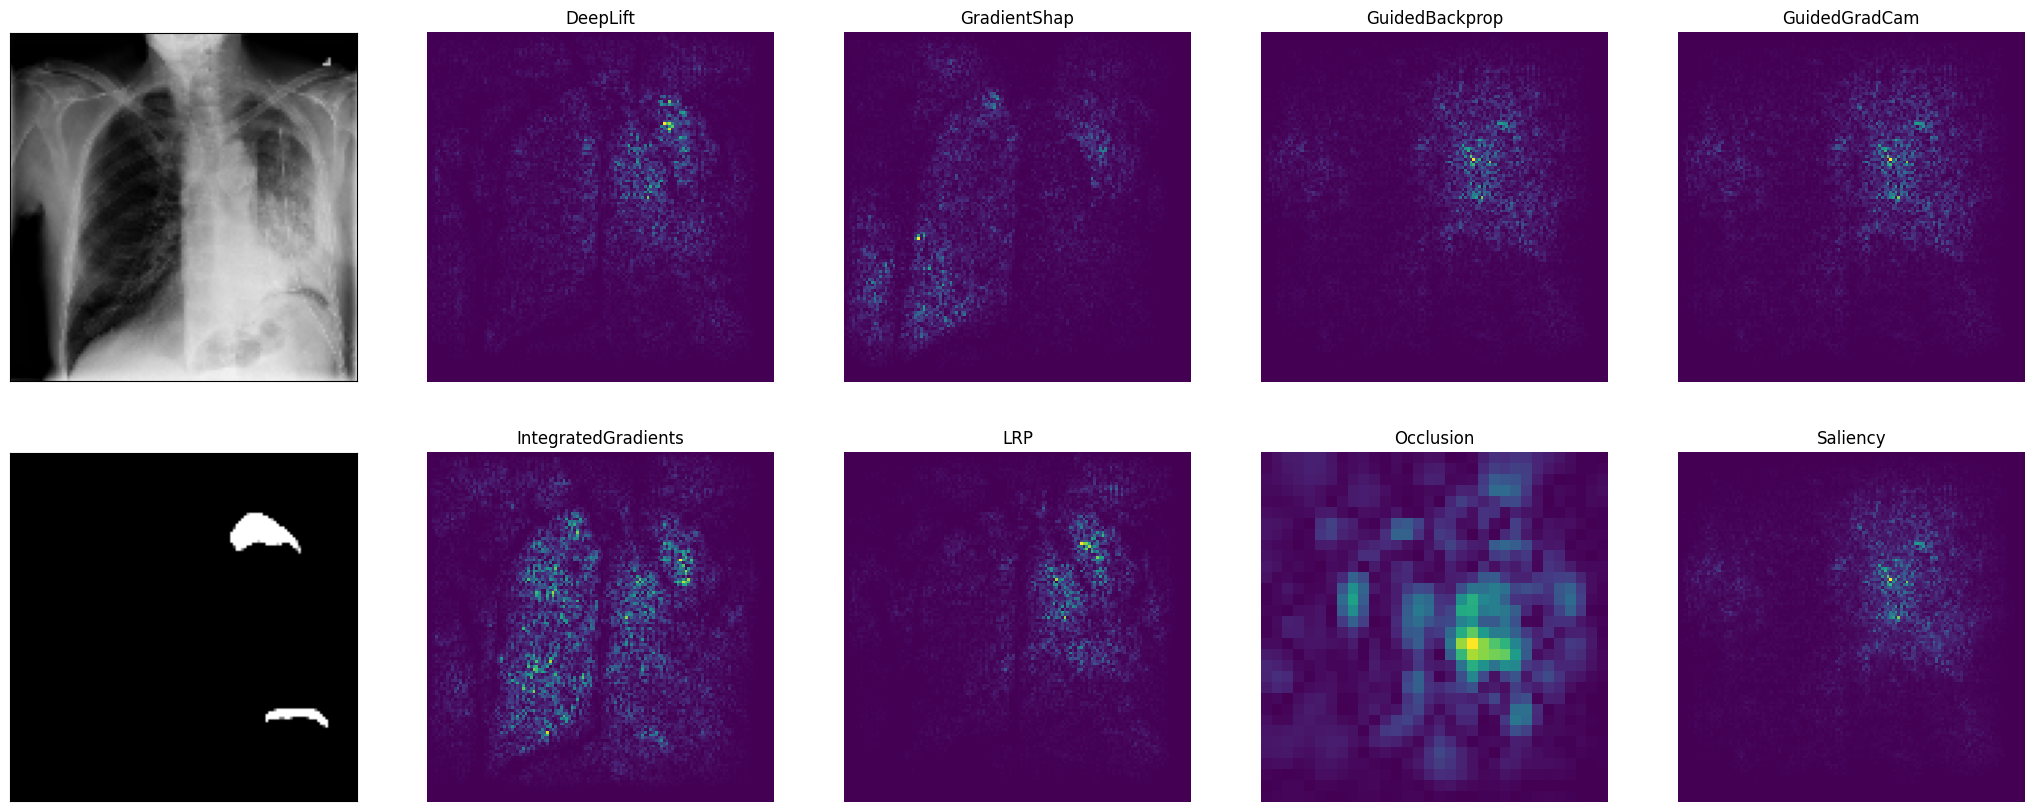

In [21]:

with open(os.path.join(utils.SAVED_EXPLANATIONS_DIR, 'test_files.json'), 'r') as fig:
    test_files = json.load(fig)
masks = load_mask()
explanations = explanations_pneumothorax
fig_inceptionv3, _ = visualize_sample_saliency(test_files, masks, explanations, 'InceptionV3', methods, 0)
fig_inceptionv3.savefig(os.path.join(utils.FIGURES_PATH, 'shape-comparison-inceptionv3.png'), bbox_inches='tight')
plt.show()

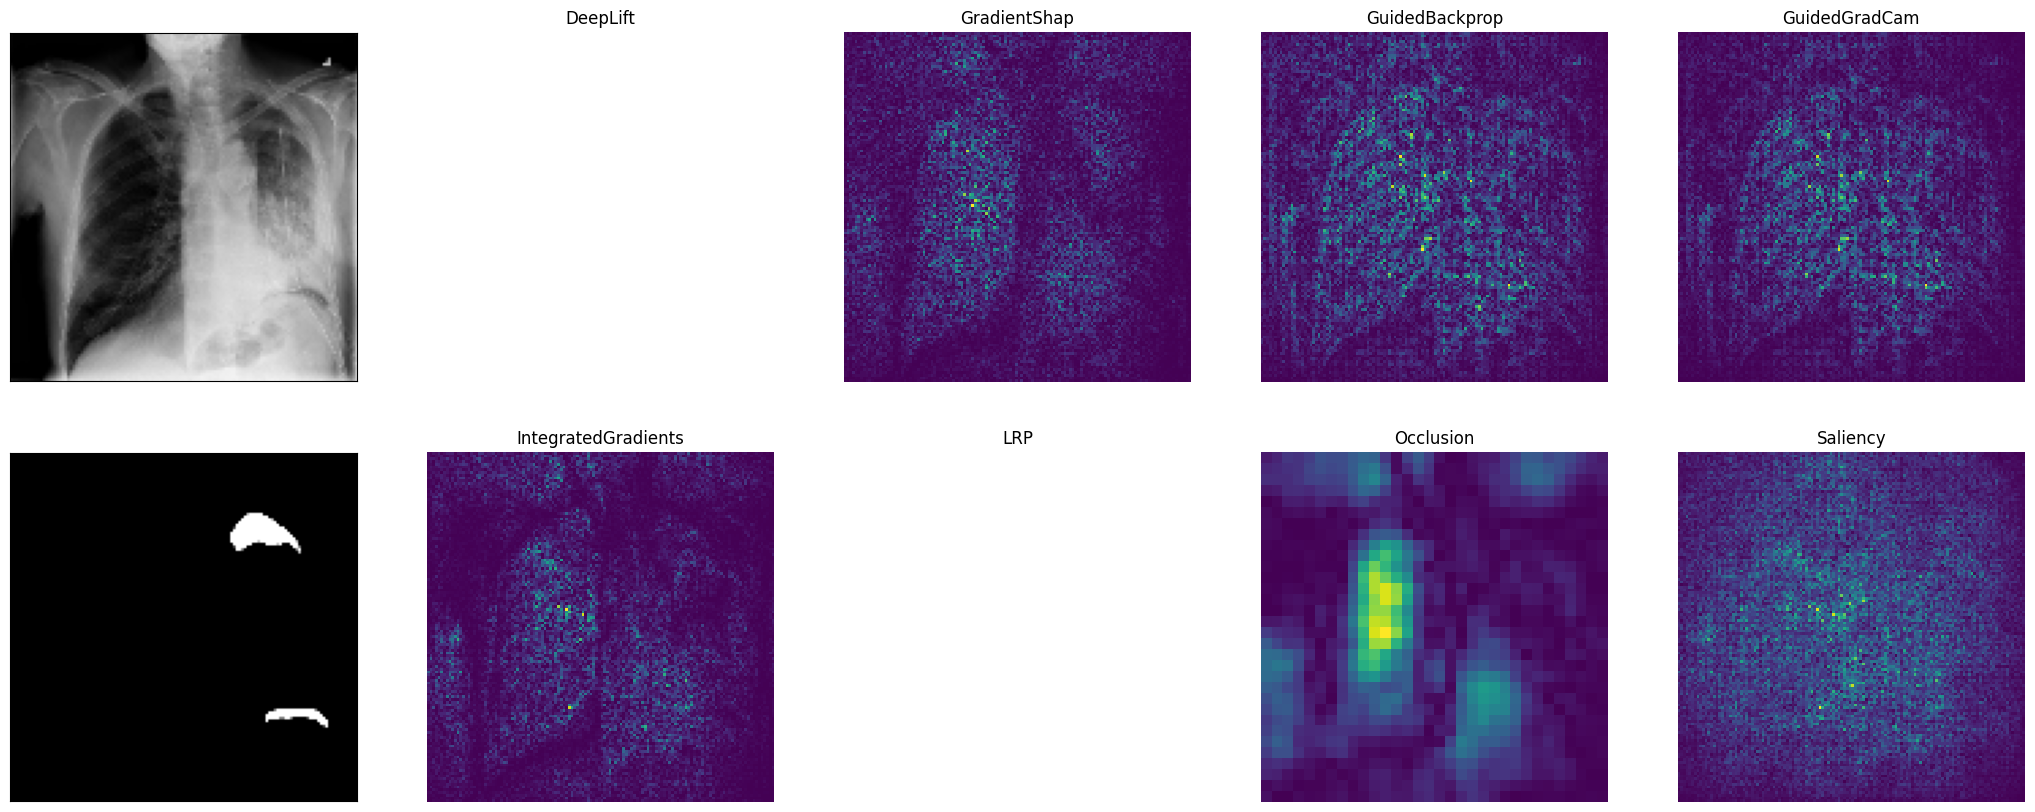

In [22]:
fig_resnet, _ = visualize_sample_saliency(test_files, masks, explanations, 'ResNet', methods, 0)
fig_resnet.savefig(os.path.join(utils.FIGURES_PATH, 'shape-comparison-resnet.png'), bbox_inches='tight')
plt.show()

# Visualize saliency maps value distribution

In [23]:
def plot_saliency_distribution(explanations, blackbox, methods):
    num_methods = len(methods)
    fig, axes = plt.subplots(4, 2, figsize=(8, 10), sharey=True)
    fig.tight_layout(w_pad=1, h_pad=1.5)
    
    for i, ax in enumerate(axes.flat):
        if i >= num_methods:
            ax.axis('off')
            continue

        topk = explanations[blackbox][methods[i]]
        topk = topk[get_top_k(topk, 1000)]
        sns.histplot(topk.numpy(), ax=ax).set(title=methods[i])
        
    return fig, axes

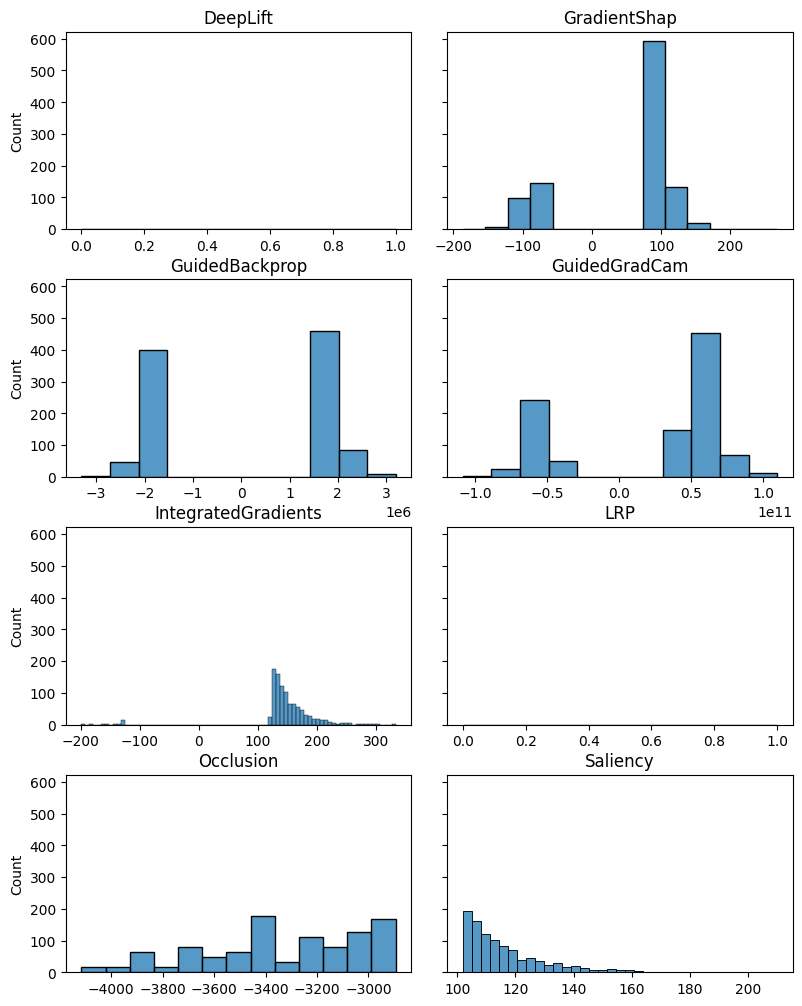

In [24]:
fig_dis_resnet, _ = plot_saliency_distribution(explanations, 'ResNet', methods)
fig_dis_resnet.savefig(os.path.join(utils.FIGURES_PATH, 'saliency-maps-value-distribution-resnet.png'), bbox_inches='tight')
plt.show()

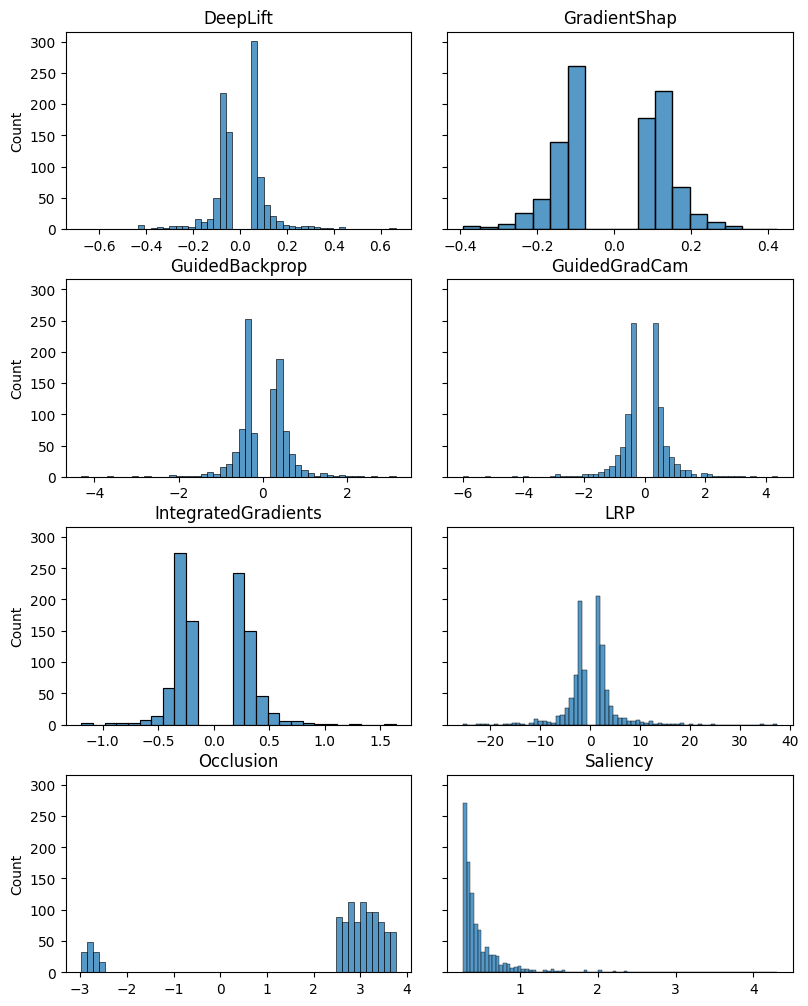

In [25]:
fig_dis_inceptionv3, _ = plot_saliency_distribution(explanations, 'InceptionV3', methods)
fig_dis_inceptionv3.savefig(os.path.join(utils.FIGURES_PATH, 'saliency-maps-value-distribution-inceptionv3.png'), bbox_inches='tight')
plt.show()

# Visualize for metric demonstration

In [26]:
method1, method2 = 'IntegratedGradients', 'GuidedBackprop'
example_index = 0

ax = explanations['InceptionV3'][method1][example_index]
b = explanations['InceptionV3'][method2][example_index]

k = 820
top_a = get_top_k(ax.abs(), k)
top_b = get_top_k(b.abs(), k)

In [27]:
def plot(exp):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(exp)
    ax.axis('off')
    return fig, ax

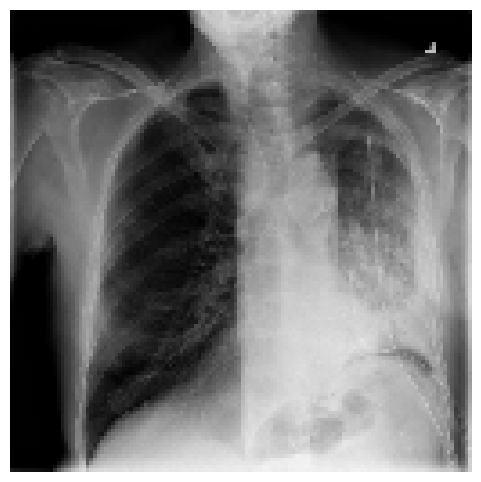

In [28]:
fig_inp, _ = plot(get_image_as_tensor(test_files[example_index]).permute(1, 2, 0))
fig_inp.savefig(os.path.join(utils.FIGURES_PATH, 'demo_fa/input'))

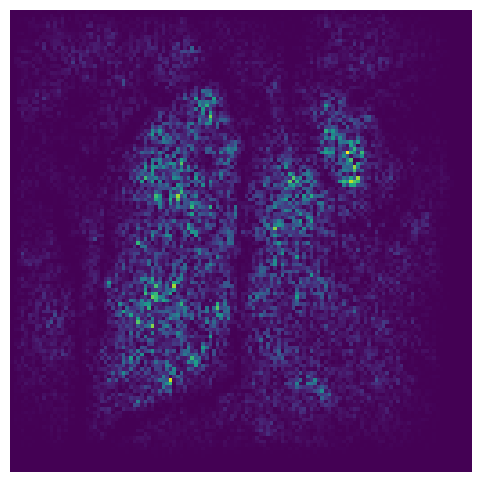

In [29]:
fig1, ax1 = plot(ax.abs())
fig1.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/{method1}'), bbox_inches='tight')

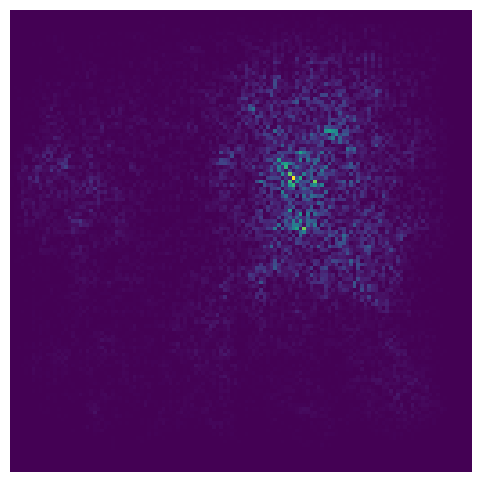

In [30]:
fig2, ax2 = plot(b.abs())
fig2.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/{method2}'), bbox_inches='tight')

In [31]:
def get_extent(fig, ax):
    return ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

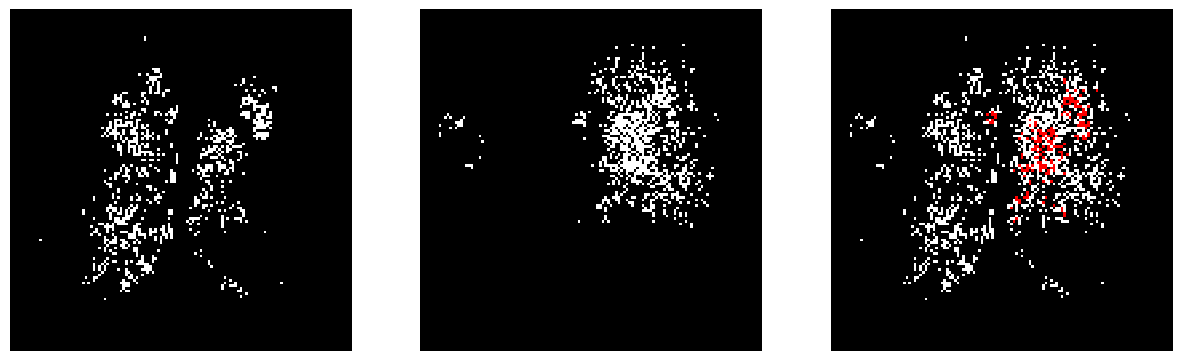

In [32]:
fig_fa_demo, axes_fa_demo = plt.subplots(1, 3, figsize=(15, 6))

axes_fa_demo[0].matshow(top_a, cmap='gray')
axes_fa_demo[1].matshow(top_b, cmap='gray')

cmap = colors.ListedColormap(['black', 'red', 'white'])
bounds = [0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)

intersect = (top_a == True) & (top_a == top_b)
union = (top_a == True) | (top_b  == True)
t = torch.zeros_like(top_a, dtype=int)
t[intersect] = 1
b_false = top_b == False
a_false = top_a == False
t[union & b_false] = 2
t[union & a_false] = 2
axes_fa_demo[2].matshow(t, cmap=cmap, norm=norm)

for ax in axes_fa_demo.flat:
    ax.axis('off')


plt.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/top-k-{method1}'), bbox_inches=get_extent(fig_fa_demo, axes_fa_demo[0]))
plt.savefig(os.path.join(utils.FIGURES_PATH, f'demo_fa/top-k-{method2}'), bbox_inches=get_extent(fig_fa_demo, axes_fa_demo[1]))
plt.savefig(os.path.join(utils.FIGURES_PATH, 'demo_fa/intersect'), bbox_inches=get_extent(fig_fa_demo, axes_fa_demo[2]))
plt.show()